# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
import cv2
import os
import requests
import math
import numpy as np

from matplotlib import pyplot as plt
from scipy import signal
from scipy.io import loadmat

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/"

mr_data_FILENAME = "MR_data.mat"
if not os.path.exists(mr_data_FILENAME):
    r = requests.get(url + mr_data_FILENAME, allow_redirects=True)
    open(mr_data_FILENAME, "wb").write(r.content)

mr_data = loadmat(mr_data_FILENAME)

niose_free_image, noisy1_image, noisy2_image, noisy3_image, noisy4_image = [
    mr_data[filename]
    for filename in ["I_noisefree", "I_noisy1", "I_noisy2", "I_noisy3", "I_noisy4"]
]

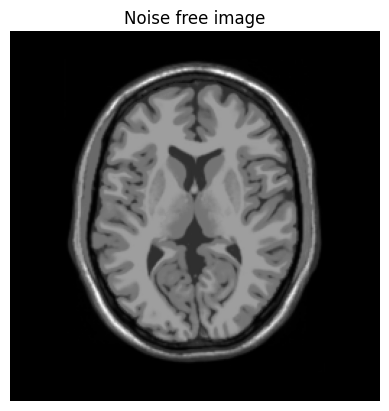

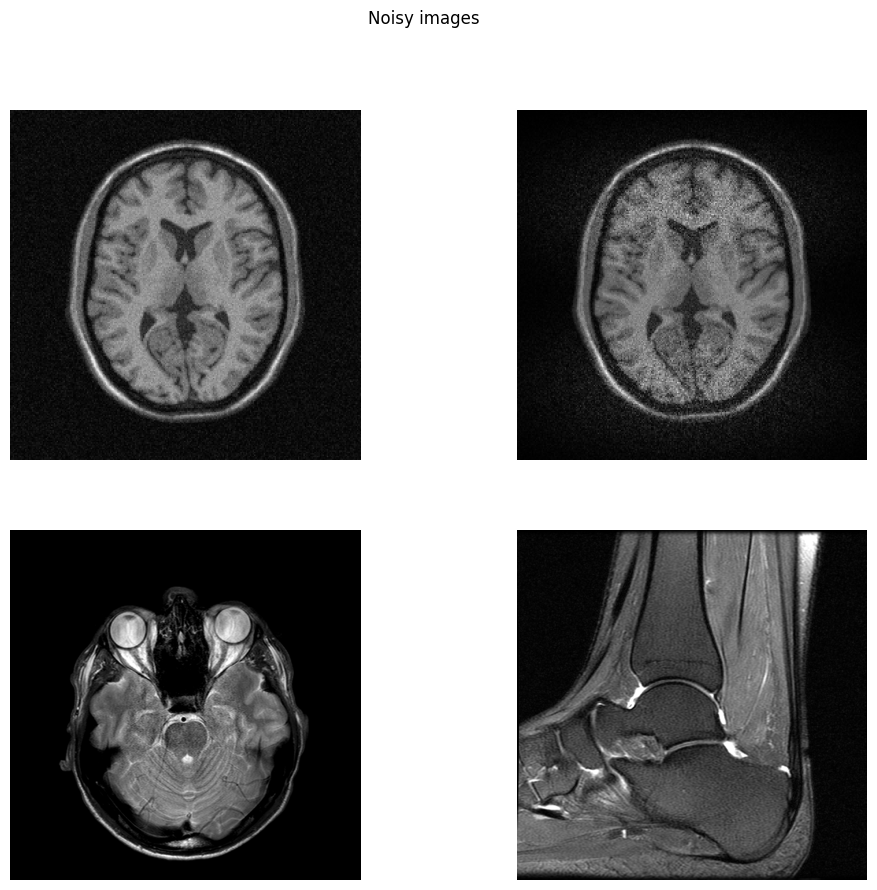

In [2]:
def show_grayscale_image(
    ax, image, title=None, full_scale: bool = False, vmin=None, vmax=None, cmap="gray"
):
    vmin, vmax = (0, 256) if full_scale else (vmin, vmax)
    ax.axis("off")
    ax.imshow(image, cmap, vmin=vmin, vmax=vmax)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)


show_grayscale_image(plt, niose_free_image, title="Noise free image")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Noisy images")

for ax, image in zip(
    [ax for ax_row in axs for ax in ax_row],
    [noisy1_image, noisy2_image, noisy3_image, noisy4_image],
):
    show_grayscale_image(ax, image)

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.

In [3]:
WINDOW_SIZE = 9
SIGMA = 2

2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.

In [14]:
from math import floor


def gaussian_filer(size, sigma):
    def gauss_fun(d, sigma):
        return np.exp(-(d**2) / (2 * sigma**2))

    middle = size // 2
    result = np.zeros(shape=(size, size))
    for y in range(size):
        for x in range(size):
            result[y, x] = gauss_fun(
                np.sqrt((x - middle) ** 2 + (y - middle) ** 2), sigma
            )
    result /= result.sum()
    return result


def validate_window_size(window_size: int):
    assert (
        window_size > 0
    ), f"`window_size` must be a positive number, but was {window_size}"
    assert (
        window_size % 2 == 1
    ), f"`window_size` must be an odd number, but was {window_size}"

def convolution(image, window_size: int, sigma: float):
    validate_window_size(window_size)

    def new_pixel_value(surrounding, filter):
        return np.sum(surrounding * filter)

    filter = gaussian_filer(window_size, sigma)

    height, width = image.shape
    window_range = floor(window_size / 2)
    result_image = image.copy()
    for y in range(window_range, height - window_range):
        for x in range(window_range, width - window_range):
            result_image[y, x] = new_pixel_value(
                surrounding=image[
                    y - window_range : y + window_range + 1,
                    x - window_range : x + window_range + 1,
                ].copy(),
                filter=filter,
            )

    return np.round(result_image).astype(np.uint8)

8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

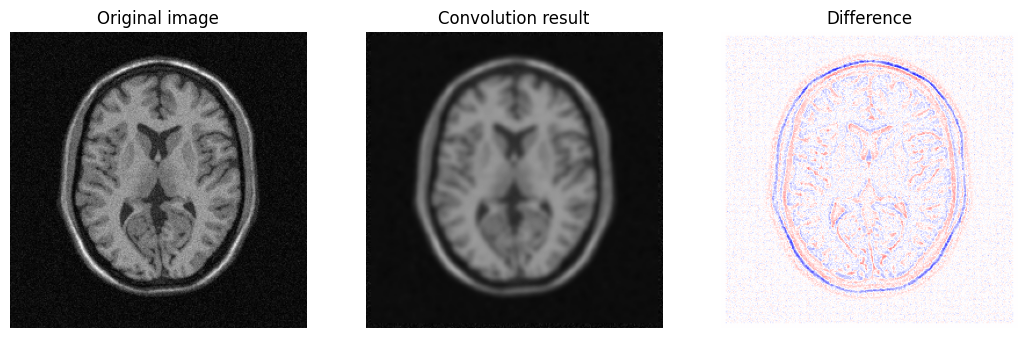

In [17]:
def present_image_difference(original_image, result_image):
    diff_image = result_image - original_image
    max_diff_val = max(diff_image.max(), -diff_image.min())

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(13, 4))

    show_grayscale_image(ax1, original_image, title="Original image", full_scale=True)
    show_grayscale_image(ax2, result_image, title="Convolution result", full_scale=True)
    show_grayscale_image(
        ax3,
        diff_image,
        title="Difference",
        cmap="bwr",
        vmin=-max_diff_val,
        vmax=max_diff_val,
    )

convoluted_image = convolution(image=noisy1_image, window_size=WINDOW_SIZE, sigma=SIGMA)

present_image_difference(noisy1_image, convoluted_image)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.

In [6]:
SIGMA_R=50

3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.

In [18]:
def bilateral_convolution(image, window_size: int, sigma: float, sigma_r: float):
    validate_window_size(window_size)

    def gamma(brightness_diff):
        return np.exp(-brightness_diff**2 / (2 * sigma_r**2))

    def new_pixel_value(surrounding, filter, pixel_value):
        altered_window = filter * gamma(pixel_value - surrounding)

        return np.sum(altered_window * surrounding) / np.sum(altered_window)
    
    filter = gaussian_filer(window_size, sigma)

    height, width = image.shape
    window_range = floor(window_size / 2)
    result_image = image.copy()
    for y in range(window_range, height - window_range):
        for x in range(window_range, width - window_range):
            result_image[y, x] = new_pixel_value(
                surrounding=image[
                    y - window_range : y + window_range + 1,
                    x - window_range : x + window_range + 1,
                ].copy(),
                filter=filter,
                pixel_value=image[y, x],
            )

    return np.round(result_image).astype(np.uint8)

11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

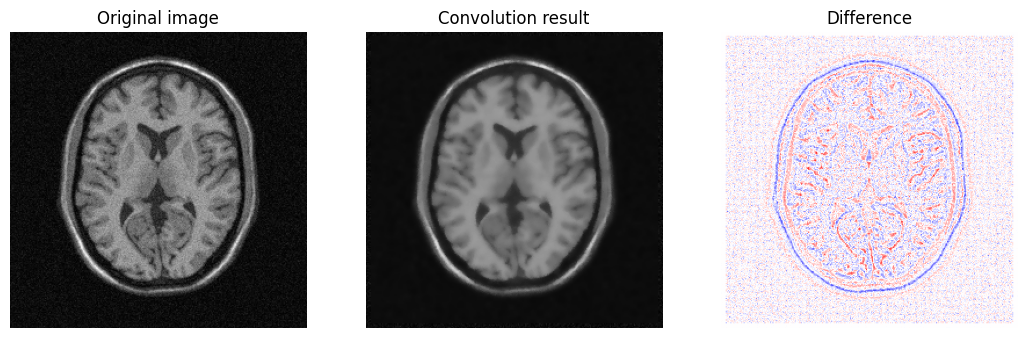

In [19]:
convoluted_image = bilateral_convolution(image=noisy1_image, window_size=WINDOW_SIZE, sigma=SIGMA, sigma_r=SIGMA_R)

present_image_difference(noisy1_image, convoluted_image)